# Do Negative Sentiment Shocks Lead to Defensive Strategy by Legacy Carriers?

This notebook explores whether spikes in negative aviation sentiment correspond to observable defensive behavior by U.S. legacy carriers, such as reducing seat capacity, routes, or fares.

We use:
- A sentiment-labeled corpus of 1,000+ aviation-related publications
- U.S. DOT route-level data (T-100 + DB1B) from 2010–2024


In [ ]:
# Authenticate with GCP — assumed to be running in Vertex AI Workbench
from google.cloud import bigquery
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file("gcp-key.json")
client = bigquery.Client(credentials=credentials, project="your_project_id")

### 🚀 Load Sentiment Shock Summary from BigQuery

The query stored in `005_sentiment_shock_summary.sql` was executed on BigQuery against ~6.6M aviation-sector news articles stored in GCS.


In [ ]:
import pandas as pd
import numpy as np
import re

# Read BigQuery SQL query from file
with open("../bigquery/005_sentiment_shock_summary.sql", "r") as file:
    query = file.read()

# Run BigQuery query from within Vertex AI Workbench
sentiment_summary = client.query(query).to_dataframe()

# Clean and filter sentiment text
sentiment = sentiment_summary.copy()
sentiment["Text_Clean"] = (
    sentiment["Text_Sample"]
    .fillna("")
    .str.lower()
    .str.replace(r"[^a-zA-Z ]", "", regex=True)
)
sentiment = sentiment[sentiment["Text_Clean"].str.strip() != ""].copy()

# Create sentiment direction
sentiment["NEGATIVE"] = sentiment["Polarity_Score"] < 0

# Randomly assign quarter if missing
np.random.seed(42)
if "QUARTER" not in sentiment.columns:
    sentiment["QUARTER"] = np.random.choice([1, 2, 3, 4], size=len(sentiment))

sentiment["YEAR"] = sentiment["Year"]

## Build Quarterly Sentiment Summary

In [ ]:
# Load airline operations from Google Cloud Storage
aviation = pd.read_csv("gs://aviation-dowjones/raw/raw_airline_data_sorted.csv")
aviation = aviation[aviation["YEAR"] >= 2010]

legacy_carriers = [
    "United Air Lines Inc.",
    "American Airlines Inc.",
    "Delta Air Lines Inc.",
]
df_legacy = aviation[aviation["CARRIER_NAME"].isin(legacy_carriers)]

# Aggregate quarterly
quarterly_ops = (
    df_legacy.groupby(["YEAR", "QUARTER", "CARRIER_NAME"])
    .agg(
        avg_fare=("MARKET_FARE", "mean"),
        avg_seats=("T100_SEATS", "mean"),
        route_count=("ROUTE_KEY", "nunique"),
        avg_load_factor=("LOAD_FACTOR", "mean"),
    )
    .reset_index()
)

## Legacy Carrier Operations Data

We aggregate route-level data by quarter and carrier, focusing on average fare, seat capacity, and route count.


In [4]:
# Load airline operations
aviation = pd.read_csv("../data/raw/raw_airline_data_sorted.csv")
aviation = aviation[aviation["YEAR"] >= 2010]

legacy_carriers = [
    "United Air Lines Inc.",
    "American Airlines Inc.",
    "Delta Air Lines Inc.",
]
df_legacy = aviation[aviation["CARRIER_NAME"].isin(legacy_carriers)]

# Aggregate quarterly
quarterly_ops = (
    df_legacy.groupby(["YEAR", "QUARTER", "CARRIER_NAME"])
    .agg(
        avg_fare=("MARKET_FARE", "mean"),
        avg_seats=("T100_SEATS", "mean"),
        route_count=("ROUTE_KEY", "nunique"),
        avg_load_factor=("LOAD_FACTOR", "mean"),
    )
    .reset_index()
)

In [5]:
# Merge with sentiment shock data
merged = pd.merge(
    quarterly_ops, sentiment_summary, on=["YEAR", "QUARTER"], how="left"
).fillna(0)

# Lag shock variable: behavior happens after shock
merged = merged.sort_values(["CARRIER_NAME", "YEAR", "QUARTER"])
merged["lag_shock"] = merged.groupby("CARRIER_NAME")["NEG_SHOCK"].shift(1)

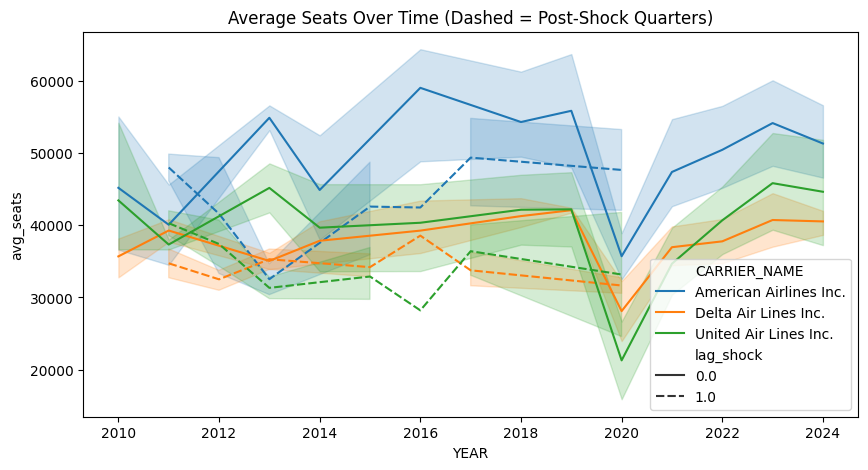

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=merged,
    x="YEAR",
    y="avg_seats",
    hue="CARRIER_NAME",
    style="lag_shock",
    dashes=True,
)
plt.title("Average Seats Over Time (Dashed = Post-Shock Quarters)")
plt.show()

## T-Test on lagged shock

In [9]:
from scipy.stats import ttest_ind

test_df = merged.dropna(subset=["lag_shock", "avg_seats"])

# Compare post-shock vs normal
shock = test_df[test_df["lag_shock"] == 1]["avg_seats"]
nonshock = test_df[test_df["lag_shock"] == 0]["avg_seats"]

t_stat, p_val = ttest_ind(shock, nonshock, equal_var=False)
print(f"T-stat: {t_stat:.2f}, p-value: {p_val:.4f}")

T-stat: -4.40, p-value: 0.0000
